In [22]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [23]:
import datetime
import spiceypy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

spiceypy.furnsh("meta_3.txt")

In [24]:
INIT_TIME_UTC = datetime.datetime(year=2000, month=1, day=1, hour=0, minute=0, second=0)

# Add a number of days; you can play around with the datetime variables; but
# leave it as it is for the first try, since other computations and comments
# are based on this value.
DELTA_DAYS = 10000
END_TIME_UTC = INIT_TIME_UTC + datetime.timedelta(days=DELTA_DAYS)

# Convert the datetime objects now to strings
INIT_TIME_UTC_STR = INIT_TIME_UTC.strftime("%Y-%m-%dT%H:%M:%S")
END_TIME_UTC_STR = END_TIME_UTC.strftime("%Y-%m-%dT%H:%M:%S")

# Print the starting and end times
print(f"Init time in UTC: {INIT_TIME_UTC_STR}")
print(f"End time in UTC: {END_TIME_UTC_STR}")

# Convert to Ephemeris Time (ET) using the SPICE function utc2et
INIT_TIME_ET = spiceypy.utc2et(INIT_TIME_UTC_STR)
END_TIME_ET = spiceypy.utc2et(END_TIME_UTC_STR)

# Create a numpy array that covers a time interval in delta = 1 day step
TIME_INTERVAL_ET = np.linspace(INIT_TIME_ET, END_TIME_ET, DELTA_DAYS)

Init time in UTC: 2000-01-01T00:00:00
End time in UTC: 2027-05-19T00:00:00


In [25]:
_, RADII_SUN = spiceypy.bodvcd(bodyid=10, item="RADII", maxn=3)

RADIUS_SUN = RADII_SUN[0]

In [26]:
SOLAR_SYSTEM_DF = pd.DataFrame()

SOLAR_SYSTEM_DF.loc[:, "ET"] = TIME_INTERVAL_ET

SOLAR_SYSTEM_DF.loc[:, "UTC"] = SOLAR_SYSTEM_DF["ET"].apply(
    lambda x: spiceypy.et2datetime(et=x).date()
)

In [27]:
SOLAR_SYSTEM_DF.loc[:, "POS_SSB_WRT_SUN"] = SOLAR_SYSTEM_DF["ET"].apply(
    lambda x: spiceypy.spkgps(targ=0, et=x, ref="ECLIPJ2000", obs=10)[0]
)

SOLAR_SYSTEM_DF.loc[:, "POS_SSB_WRT_SUN_SCALED"] = SOLAR_SYSTEM_DF[
    "POS_SSB_WRT_SUN"
].apply(lambda x: x / RADIUS_SUN)

SOLAR_SYSTEM_DF.loc[:, "SSB_WRT_SUN_SCALED_DIST"] = SOLAR_SYSTEM_DF[
    "POS_SSB_WRT_SUN_SCALED"
].apply(lambda x: spiceypy.vnorm(x))

SOLAR_SYSTEM_DF

,ET,UTC,POS_SSB_WRT_SUN,POS_SSB_WRT_SUN_SCALED,SSB_WRT_SUN_SCALED_DIST
0,-4.313582e+04,2000-01-01,"[1068000.1891061615, 417680.9418664607, -30844...","[1.5344830303249446, 0.6001162957851447, -0.04...",1.648254
1,4.327283e+04,2000-01-02,"[1067195.5017360714, 418789.11029741366, -3083...","[1.5333268703104475, 0.6017084918066288, -0.04...",1.647758
2,1.296815e+05,2000-01-03,"[1066389.5596805303, 419896.06924681185, -3081...","[1.5321689075869689, 0.6032989500672584, -0.04...",1.647262
3,2.160901e+05,2000-01-04,"[1065582.365061001, 421001.82313176966, -30802...","[1.5310091452025876, 0.6048876769134621, -0.04...",1.646766
4,3.024987e+05,2000-01-05,"[1064773.9198190796, 422106.3763607678, -30788...","[1.5298475859469534, 0.6064746786792641, -0.04...",1.646269
...,...,...,...,...,...
9995,8.636112e+08,2027-05-14,"[4663.265215005825, 653522.8491930669, -10147....","[0.006700093699721013, 0.938969610909579, -0.0...",0.939107
9996,8.636976e+08,2027-05-15,"[3986.9114982562483, 652910.4356407273, -10131...","[0.005728321118184265, 0.9380897063803553, -0....",0.938220
9997,8.637841e+08,2027-05-16,"[3311.597377454852, 652297.295702135, -10115.7...","[0.004758042208986856, 0.9372087581927226, -0....",0.937334
9998,8.638705e+08,2027-05-17,"[2637.3234622905757, 651683.4323080052, -10099...","[0.0037892578481186433, 0.9363267705574787, -0...",0.936447


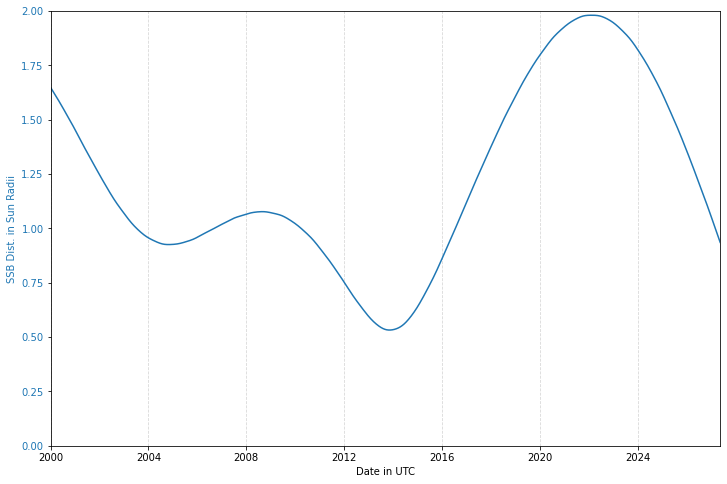

In [28]:
FIG, AX = plt.subplots(figsize=(12, 8))

AX.plot(
    SOLAR_SYSTEM_DF["UTC"], SOLAR_SYSTEM_DF["SSB_WRT_SUN_SCALED_DIST"], color="tab:blue"
)

AX.set_xlabel("Date in UTC")
AX.set_ylabel("SSB Dist. in Sun Radii", color="tab:blue")
AX.tick_params(axis="y", labelcolor="tab:blue")

AX.set_xlim(min(SOLAR_SYSTEM_DF["UTC"]), max(SOLAR_SYSTEM_DF["UTC"]))
AX.set_ylim(0, 2)

AX.grid(axis="x", linestyle="dashed", alpha=0.5)

plt.savefig("SSB2SUN_DISTANCE.png", dpi=300)